# Create and run a particle tracking

Project specific variables are imported in the model_spec.py and gen_mod_dict.py files that must be included in the notebook directory. The first first includes pathnames to data sources that will be different for each user. The second file includes a dictionary of model-specific information such as  cell size, default hydraulic parameter values, and scenario defintion (e.g. include bedrock, number of layers, etc.). There are examples in the repository. Run the following cells up to the "Run to here" cell to get a pull-down menu of models in the model_dict. Then, without re-running that cell, run all the remaining cells.  Re-running the following cell would re-set the model to the first one in the list, which you probably don't want. If you use the notebook option to run all cells below, it runs the cell you're in, so if you use that option, move to the next cell (below the pull-down menu of models) first.

In [1]:
__author__ = 'Jeff Starn'
%matplotlib notebook
from model_specs import *
from gen_mod_dict import *

import os, sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from flopy.utils.postprocessing import get_water_table


import flopy.utils.binaryfile as bf
from flopy.utils import Util2d
from matplotlib import colors
import flopy as fp
import pandas as pd
# import ipyparallel as ipp
# from model_specs import *
# from gen_mod_dict import *

from ipywidgets import interact, Dropdown
from IPython.display import display

The next cell is a template for making this notebook into a batch script. To do so, save this notebook as a .py file and edit it as follows. Comment out all the notebook-specific commands (drop-down menu stuff and commands preceded by %). Indent everything below the next cell twice so that it falls within the 'for' loop and the 'try' statement. Move the 'except' statement to the end of the script. Comment out lines in the cell after 'Preliminary stuff' so that the model is selected in the 'for' loop from gen_mod_dict. You can leave the print statement in that cell uncommented. 

In [2]:
for key, value in model_dict.items():   # from "gen_mod_dict.py"
    md = key
    ms = model_dict[md]
    print('trying {}'.format(md))
    try:
        pass
    except:
        pass

trying CoastalCT
trying Assabet


In [3]:
models = list(model_dict.keys())
models.sort()
model_area = Dropdown(
    options=models,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

### Run to here to initiate notebook

First time using this notebook in this session (before restarting the notebook), run the cells up to this point. Then select your model from the dropdown list above. Move your cursor to this cell and use the toolbar menu Cell --> Run All Below.  After the first time, if you want to run another model, select your model and start running from this cell--you don't need to re-run the cells from the beginning.

## Preliminary stuff

In [51]:
md = model_area.value
ms = model_dict[md]
print('The model being processed is {}\n'.format(md))

The model being processed is CoastalCT



In [52]:
direction="backward"
weak_pass = True

In [53]:
hydro_wt = 1.0
calib=True


geo_ws = os.path.join(proj_dir, ms['ws'])
parent_ws = os.path.join(geo_ws, scenario_dir)
if calib:
    dir_name = '{}_cal_wt_{:4.2f}'.format(scenario_dir, hydro_wt)
else:
    dir_name = scenario_dir
model_ws = os.path.join(geo_ws, dir_name)

if not os.path.exists(model_ws):
    print('This calibration scenario has not been completed')

Load existing model and some packages needed for particle tracking

In [54]:
strt_dir = os.getcwd()
os.chdir(model_ws)

nam_file = '{}.nam'.format(md)
mf = fp.modflow.Modflow.load(nam_file, version='mfnwt', exe_name=mfpth, 
                             verbose=False, model_ws=model_ws, load_only=None)

bas = mf.get_package('BAS6')
dis_file = '{}.dis'.format(md)
budget_file = '{}.cbc'.format(md)

head_file = '{}.hds'.format(md)

ibound = bas.ibound


In [138]:
model_file = os.path.join(geo_ws, dir_name,'model_grid.csv')
model_grid = pd.read_csv(model_file, na_values=['nan', hnoflo])

NROW = model_grid.row.max() + 1
NCOL = model_grid.col.max() + 1
num_cells = NROW * NCOL
NLAY = num_surf_layers + 1

zones = model_grid.zone.values.reshape(NROW, NCOL)
zones = zones.astype(int)
zone_array = np.repeat(zones[np.newaxis,:,:],NLAY,axis=0)

#change 0 to 1000
zone_array[zone_array==0]=1000


#read in the discharge rates
cbb = fp.utils.CellBudgetFile(os.path.join(model_ws,md+".cbc"))
CGWD = cbb.get_data(text=b' HEAD DEP BOUNDS')[0]
CGWD_DF = pd.DataFrame(CGWD)
CGWD_DF = CGWD_DF.rename(index=str,columns={"node":"node_num"})
#adjust the node numbering
CGWD_DF.node_num = CGWD_DF.node_num-1
model_grid = pd.merge(model_grid,CGWD_DF,"left","node_num", sort=False)
model_grid['q_int'] = -1*model_grid['q']/10
model_grid.loc[pd.isnull(model_grid.q_int),"q_int"]=0
model_grid.loc[model_grid.q_int<0,"q_int"]=0
model_grid.loc[model_grid.q_int==0,"q_int"]=-1 #preps for adding 1 to force rounding up
model_grid['q_int']=model_grid['q_int']+1
model_grid['q_int']=model_grid.q_int.astype('int8')

In [139]:
#set up the modpath run
mp = fp.modpath.Modpath(modelname = md,exe_name=mp_exe_name, modflowmodel = mf, dis_file = dis_file,budget_file = budget_file, head_file = head_file)
mp.array_free_format=True
mpb = fp.modpath.ModpathBas(mp,ibound = ibound[0,:,:], prsity=0.4,hdry=hdry)


In [140]:
if direction=="backward":
    option_flags = [2,2,1,1,1,2,1,3,1,1,1,1] #the second digit controls the tracking direction (1=forward, 2=backward)
    mask_1lay = [Util2d(mp,(NROW,NCOL),np.int,model_grid.ghb_sea.values.reshape(NROW, NCOL),name="temp")]
elif direction=="forward":
    option_flags = [2,1,1,1,1,2,1,3,1,1,1,1] #the second digit controls the tracking direction (1=forward, 2=backward)
    mask_1lay = [Util2d(mp,(NROW,NCOL),np.int,ibound[0],name="temp")]

if weak_pass:
    option_flags[2:4]=[1,1]
else:
    option_flags[2:4]=[2,2]
group_placement = [[1,3,1,0,1,1]]
mask_layer='0'

sim = fp.modpath.mpsim.ModpathSim(mp,md+".mpnam",md+".mplst",option_flags=option_flags,group_placement=group_placement,mask_layer=mask_layer, mask_1lay=mask_1lay,face_ct=[1], ifaces=[[[6,1,1]]])

In [141]:
mp.write_input()
success, output = mp.run_model()


FloPy is using the following executable to run the model: C:/workspace/gw-general-models/Genmod1.0/executables/modpath.6_0/bin/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+05                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


In [142]:
epobj = fp.utils.EndpointFile(mp.name+'.mpend')
ep_all = epobj.get_alldata()

stats_txt = "ALL PARTICLES\nMODPATH TRAVEL TIME STATS [Days (Years)]\n\n"

percent_list = [0,25,50,75,100]
name_list=["Min","Q1","Median","Q3","Max"]

for i in range(len(percent_list)):
    thispercent = percent_list[i]
    thisname = name_list[i]
    stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%(str(thisname),np.percentile(ep_all["finaltime"],int(thispercent)),np.percentile(ep_all["finaltime"],int(thispercent))/365)
    
stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%("Mean",np.mean(ep_all["finaltime"]),np.mean(ep_all["finaltime"])/365)
stats_txt = stats_txt + "%-10s%10.0f\n"%("Count",ep_all.shape[0])

print(stats_txt)

ALL PARTICLES
MODPATH TRAVEL TIME STATS [Days (Years)]

Min                0 (0)
Q1             28540 (78)
Median        102640 (281)
Q3            374912 (1027)
Max       97707597824 (267692049)
Mean        67280864 (184331)
Count           8549



In [143]:
stats_txt = "PARTICLES WITH TRAVEL TIME >= 1 DAY\nMODPATH TRAVEL TIME STATS [Days (Years)]\n\n"

ep_all_temp = ep_all[ep_all['finaltime']>0]

percent_list = [0,25,50,75,100]
name_list=["Min","Q1","Median","Q3","Max"]

for i in range(len(percent_list)):
    thispercent = percent_list[i]
    thisname = name_list[i]
    stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%(str(thisname),np.percentile(ep_all_temp["finaltime"],int(thispercent)),np.percentile(ep_all_temp["finaltime"],int(thispercent))/365)
    
stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%("Mean",np.mean(ep_all_temp["finaltime"]),np.mean(ep_all_temp["finaltime"])/365)
stats_txt = stats_txt + "%-10s%10.0f\n"%("Count",ep_all_temp.shape[0])

print(stats_txt)

PARTICLES WITH TRAVEL TIME >= 1 DAY
MODPATH TRAVEL TIME STATS [Days (Years)]

Min               23 (0)
Q1             30958 (85)
Median        105783 (290)
Q3            384421 (1053)
Max       97707597824 (267692049)
Mean        68327872 (187200)
Count           8418



In [144]:
#save the endpoint file
np.savetxt(md+"_EndpointAll.csv",ep_all,delimiter=",",fmt="%s",header=",".join(ep_all.dtype.names))

if direction=="forward":
    traveltimes_dis = mlab.rec_groupby(ep_all,('i','j'),(('finaltime',np.median,'medTime_days'),))
elif direction=="backward":
    traveltimes_dis = mlab.rec_groupby(ep_all,('i0','j0'),(('finaltime',np.median,'medTime_days'),))
    traveltimes_dis.dtype.names=['i','j','medTime_days']
np.savetxt(md+"_EndpointSummary.csv",traveltimes_dis,delimiter=",",fmt="%s",header=",".join(traveltimes_dis.dtype.names))

In [145]:
#add the travel time info to the model_grid
traveltimesDF = pd.DataFrame(traveltimes_dis)
model_grid2 = pd.merge(model_grid,traveltimesDF,left_on=['row','col'], right_on=['i','j'], how="left")
model_grid2['medTime_yrs'] = model_grid2['medTime_days']/365.

#resave the model grid
model_grid2.to_csv(model_file.replace("model_grid","model_grid2"))

In [146]:
#plot the coastal discharge travel times
coastalTravelTimesDF = pd.DataFrame(ep_all_temp)
coastalTravelTimesDF['finaltimeYrs'] = coastalTravelTimesDF.finaltime/365.0
if direction=="backward":
    coastalTravelTimesDF2 = pd.merge(coastalTravelTimesDF,model_grid,right_on=['row','col'], left_on=['i0','j0'], how="left")
elif direction=="forward":
    coastalTravelTimesDF2 = pd.merge(coastalTravelTimesDF,model_grid,right_on=['row','col'], left_on=['i','j'], how="left")
coastalTravelTimesDF2 = coastalTravelTimesDF2[coastalTravelTimesDF2.ghb_sea==1]
test = [[row.finaltimeYrs] * row.q_int for row in coastalTravelTimesDF2.itertuples() if row.q_int>0]
coastalTravelTimesLst = [x for sublist in test for x in sublist]


<IPython.core.display.Javascript object>


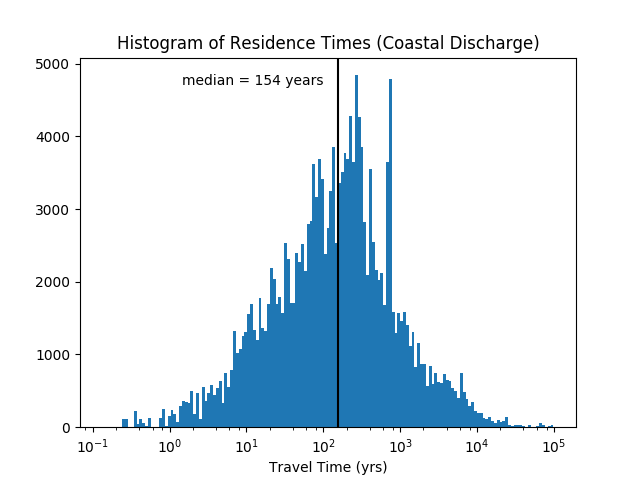

In [158]:
timeCutOff = 1e5
_, bins = np.histogram(np.log10([x for x in coastalTravelTimesLst if x < timeCutOff]), bins='auto')
plt.figure()
plt.hist([x for x in coastalTravelTimesLst if x < timeCutOff], bins=10**bins);
plt.gca().set_xscale("log")
plt.xlabel('Travel Time (yrs)')
plt.title('Histogram of Residence Times (Coastal Discharge)')
#plt.xlim([0,100])
#plt.axvline(x=25, color='r')
#plt.text(15,775,'25 years',color='r', horizontalalignment="right")
plt.axvline(x=np.nanmedian([x for x in coastalTravelTimesLst if x < timeCutOff]), color='black')
plt.text(100,4700,'median = %i years'%(int(np.nanmedian([x for x in coastalTravelTimesLst if x < timeCutOff]))),color='black', horizontalalignment="right")
plt.show()

<IPython.core.display.Javascript object>


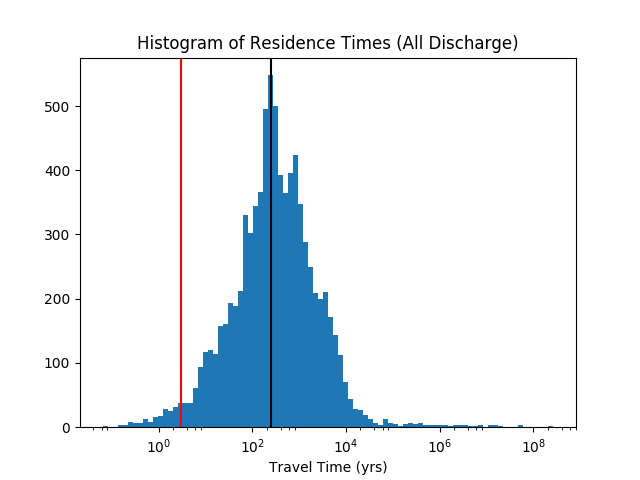

In [151]:
_, bins = np.histogram(np.log10(ep_all_temp["finaltime"]/365), bins='auto')
plt.figure()
plt.hist(ep_all_temp["finaltime"]/365, bins=10**bins);
plt.gca().set_xscale("log")
plt.xlabel('Travel Time (yrs)')
plt.title('Histogram of Residence Times (All Discharge)')
#plt.xlim([0,100])
plt.axvline(x=3, color='r')
plt.text(2,2020,'3 years',horizontalalignment='right', color='r')
plt.axvline(x=250, color='black')
plt.text(350,2020,'250 years',color='black')
plt.show()

In [47]:
ep_all[np.all([ep_all.i==294, ep_all.j==498], axis=0)]

rec.array([], 
          dtype=[('particleid', '<i4'), ('particlegroup', '<i4'), ('status', '<i4'), ('initialtime', '<f4'), ('finaltime', '<f4'), ('initialgrid', '<i4'), ('k0', '<i4'), ('i0', '<i4'), ('j0', '<i4'), ('initialcellface', '<i4'), ('initialzone', '<i4'), ('xloc0', '<f4'), ('yloc0', '<f4'), ('zloc0', '<f4'), ('x0', '<f4'), ('y0', '<f4'), ('z0', '<f4'), ('finalgrid', '<i4'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('finalcellface', '<i4'), ('finalzone', '<i4'), ('xloc', '<f4'), ('yloc', '<f4'), ('zloc', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('label', 'O')])